# BaristaSeq data SSAM analysis

In [1]:
import pandas as pd
import ssam
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
plt.rcParams["font.family"] = "Arial"

In [3]:
cell_class_colors = {
    "Lamp5": "#DA808C",
    "Sncg": "#8510C0",
    "Serpinf1": "#8510C0",
    "Vip": "#70559A",
    "Sst": "#F15A29",
    "Pvalb": "#D93137",
    "L2/3 IT": "#94D9A1",
    "L4": "#00979D",
    "L5 IT": "#008A61",
    "L6 IT": "#A19922",
    "L5 PT": "#0D5B78",
    "L5 NP": "#3E9E64",
    "L6 CT": "#69A8E6",
    "L6 PT": "#69A8E6",
    "L6b": "#266180",
    "Meis2": "#FF0000",
    "CR": "#00FF66",
    "Astro": "#665C47",
    "Oligo": "#53776C",
    "VLMC": "#697255",
    "Peri": "#665547",
    "SMC": "#807059",
    "Endo": "#8D6C62",
    "Macrophage": "#537358",    
}

In [6]:
bad_genes = ['Vxn', 'unused-1', 'unused-2', 'Plpp4', 'Lratd2']

In [7]:
spots = pd.read_csv("data/raw/BaristaSeq_all_spots_2_with_annotation.csv")

In [8]:
seg_df = pd.read_csv("data/baysor/barista_seq/segmentation.csv")
spots['cell'] = seg_df['cell'].to_numpy()

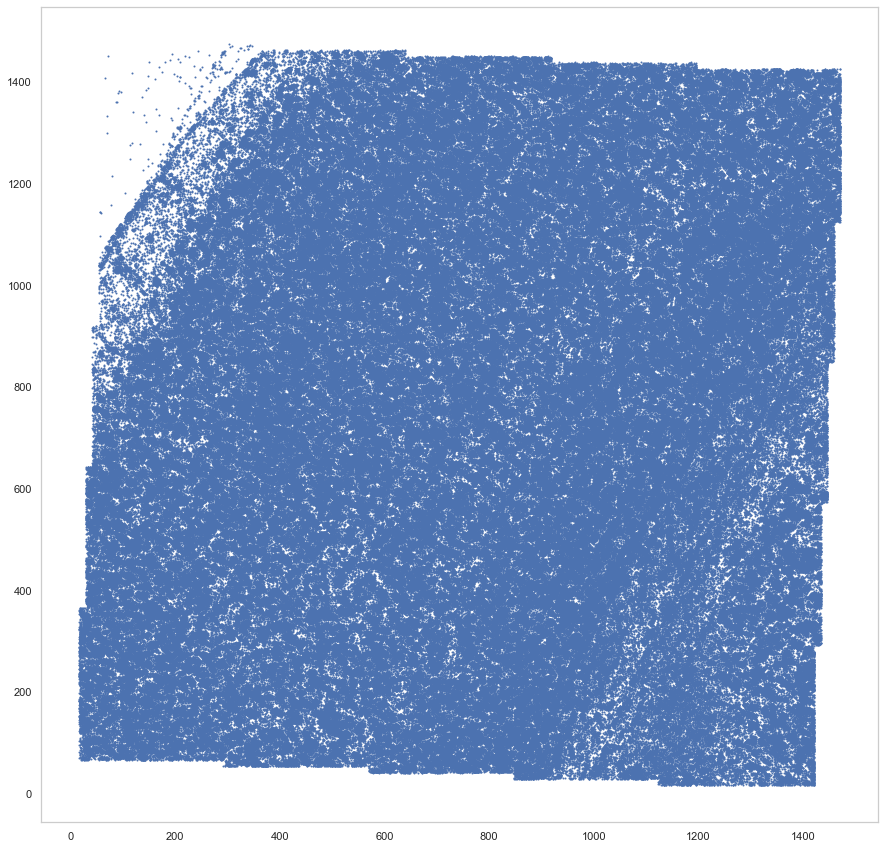

In [9]:
plt.figure(figsize=[15, 15])
plt.scatter(spots.x, spots.y, s=1)

In [10]:
spots = spots[spots.layer != "outside_VISp"]
for bad_gene in bad_genes:
    spots = spots[spots.gene != bad_gene]

In [11]:
beta = -1.04750901228598
rotm = np.array([[np.cos(beta), np.sin(beta)], [-np.sin(beta), np.cos(beta)]])
pos_um = np.array([spots.x, spots.y])
rot_um = np.dot(pos_um.T, rotm)
rot_um[:, 0] -= np.min(rot_um[:, 0])
rot_um[:, 1] -= np.min(rot_um[:, 1])

(0.0, 1350.0)

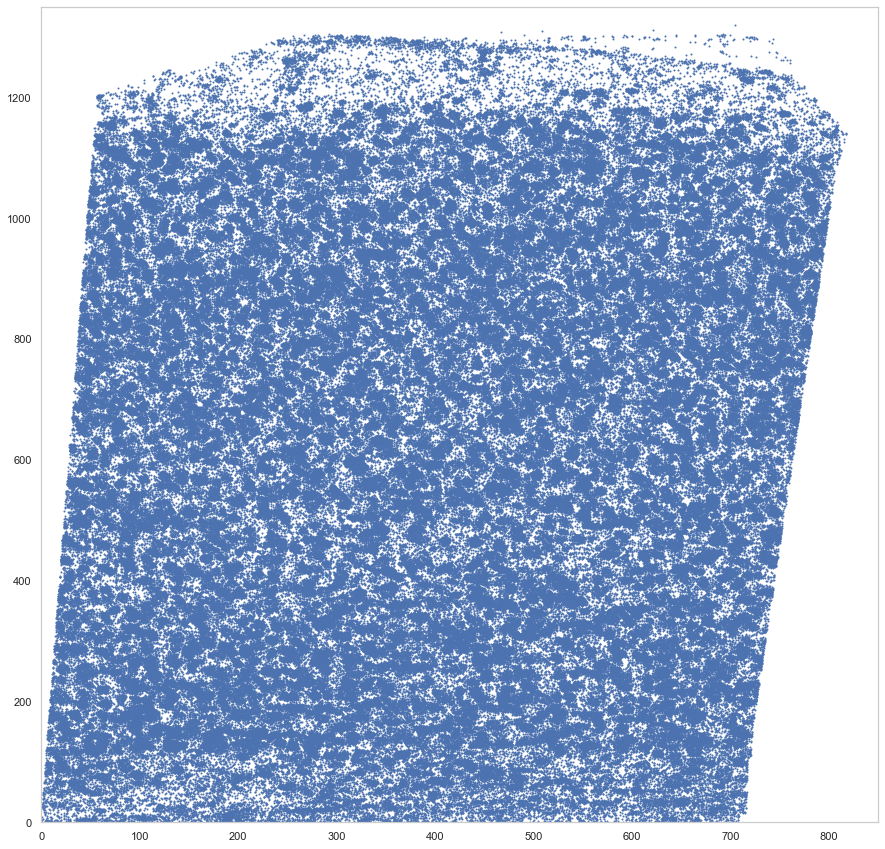

In [9]:
plt.figure(figsize=[15, 15])
plt.scatter(*rot_um.T, s=1)
plt.xlim([0, 850])
plt.ylim([0, 1350])

In [12]:
locations = spots[["gene", "x", "y", "cell"]].set_index('gene')
locations['x'] = rot_um[:, 0]
locations['y'] = rot_um[:, 1]

In [13]:
locations

x           y  cell
gene                                 
Nrgn     688.726337  277.111239  8444
Atp1a3   706.602582  287.424672  8445
Nrgn     730.389647  301.148264  8495
Adarb2   631.238166  243.759579  8409
Sparcl1  633.208728  244.896465  8409
...             ...         ...   ...
Gm11549   83.127330  902.181293  1577
Atp1a3   142.666020  936.531250     0
Atp1a3    49.789322  882.572217  1655
Gad1     122.137098  924.312185  1657
Deptor    52.263648  878.933827  1655

[403335 rows x 3 columns]

In [4]:
import ssam

In [5]:
ds = ssam.SSAMDataset("ssam_data/baristaseq")
analysis = ssam.SSAMAnalysis(ds, ncores=10, verbose=True)

In [86]:
analysis.run_kde(locations=locations, width=850, height=1350, bandwidth=5, re_run=True)

Running KDE for gene Adarb2...
Saving KDE for gene Adarb2...
Running KDE for gene Adcy2...
Saving KDE for gene Adcy2...
Running KDE for gene Ank1...
Saving KDE for gene Ank1...
Running KDE for gene Ankrd55...
Saving KDE for gene Ankrd55...
Running KDE for gene Arpp19...
Saving KDE for gene Arpp19...
Running KDE for gene Arx...
Saving KDE for gene Arx...
Running KDE for gene Atp1a3...
Saving KDE for gene Atp1a3...
Running KDE for gene Brinp3...
Saving KDE for gene Brinp3...
Running KDE for gene Btbd11...
Saving KDE for gene Btbd11...
Running KDE for gene Cacna2d3...
Saving KDE for gene Cacna2d3...
Running KDE for gene Calb1...
Saving KDE for gene Calb1...
Running KDE for gene Caln1...
Saving KDE for gene Caln1...
Running KDE for gene Car3...
Saving KDE for gene Car3...
Running KDE for gene Car4...
Saving KDE for gene Car4...
Running KDE for gene Cck...
Saving KDE for gene Cck...
Running KDE for gene Chodl...
Saving KDE for gene Chodl...
Running KDE for gene Chrna2...
Saving KDE for gene

In [6]:
analysis.load_kde()

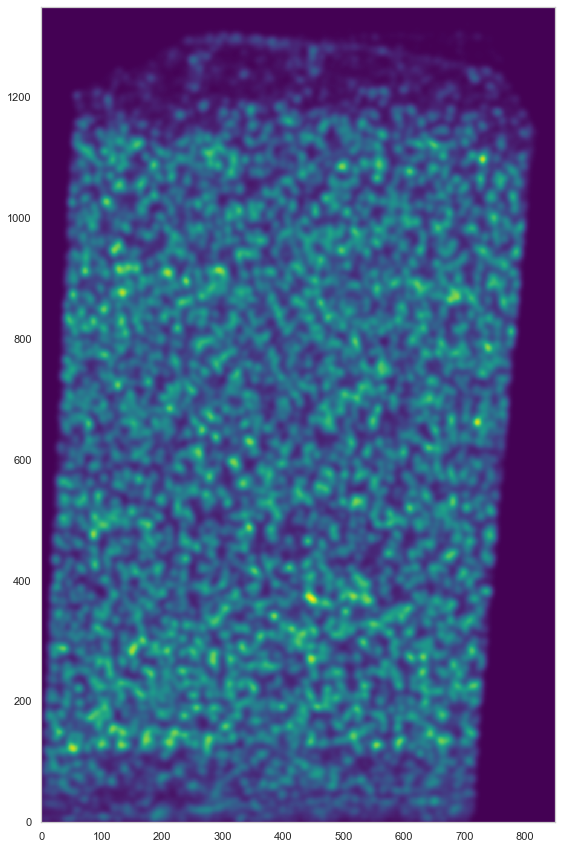

In [15]:
plt.figure(figsize=[15, 15])
ds.plot_l1norm(rotate=3)

In [16]:
analysis.find_localmax()

Found 1301 local max vectors.


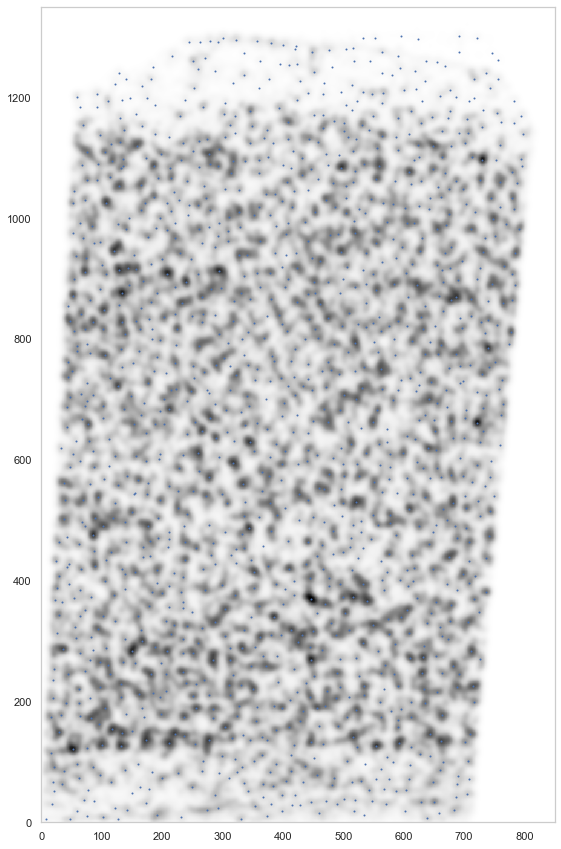

In [17]:
plt.figure(figsize=[15, 15])
ds.plot_l1norm(rotate=3, cmap="Greys")
ds.plot_localmax(rotate=3)

In [18]:
analysis.normalize_vectors(re_run=True)

Normalizing...
Processing chunk 1 (of 2)...
Processing chunk 2 (of 2)...


In [7]:
cell_by_gene = pd.read_csv("data/jeremy_filtered/BARISTAseq_filtered_cellxgene.csv")
cell_by_gene = cell_by_gene.set_index('gene_name').T[ds.genes]

In [8]:
from sklearn import preprocessing
#cell_by_gene_normalized = ssam.run_sctransform(cell_by_gene.reset_index(drop=True), plot_model_pars=True)[0]
cell_by_gene_normalized = np.log(preprocessing.normalize(cell_by_gene, norm="l1", axis=1) * 10 + 1)
cell_by_gene_normalized_scaled = preprocessing.scale(cell_by_gene_normalized)

In [9]:
from collections import defaultdict
from itertools import chain

def sort_genes(centroids, tbl, genes, min_exp=0.5):
    sorted_genes = defaultdict(lambda: [])
    sorted_cnt = 0
    while sorted_cnt < len(genes):
        for cidx, mean_cl in enumerate(centroids):
            for gidx in np.argsort(mean_cl)[::-1]:
                if all([not genes[gidx] in l for l in sorted_genes.values()]):
                    if mean_cl[gidx] < min_exp:
                        sorted_genes["rem"].append(genes[gidx])
                    else:
                        sorted_genes[cidx].append(genes[gidx])
                    sorted_cnt += 1
                    break
    sorted_genes = list(chain(*[sorted_genes[i] for i in range(len(centroids))])) + sorted_genes["rem"]
    sorted_gidx = [list(genes).index(g) for g in sorted_genes]
    return tbl[:, sorted_gidx], sorted_genes

In [10]:
def plot_heatmap(sorted_cbg, sorted_genes, calls, uniq_calls, cols, figsize):
    from sklearn import preprocessing
    from mpl_toolkits.axes_grid1 import Divider, Size
    from matplotlib import patches

    rects = []
    sorted_cbg2 = np.zeros_like(sorted_cbg)
    curpos = 0
    for idx, (cell_type, col) in enumerate(zip(uniq_calls, cols)):
        cl_vecs = sorted_cbg[calls.subclass == cell_type]
        sorted_cbg2[curpos:curpos+len(cl_vecs)] = cl_vecs
        rects.append(patches.Rectangle((curpos, 0), curpos+len(cl_vecs), 1, linewidth=0, facecolor=col))
        curpos += len(cl_vecs)


    fig = plt.figure(figsize=figsize)
    #fig, axes = plt.subplots(2, 1, figsize=[20, 10], sharex=True)

    h = [Size.Fixed(1.0), Size.Scaled(1.0)]
    v = [Size.Fixed(0), Size.Scaled(1.0), Size.Fixed(0.05), Size.Fixed(0.3)]
    divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)

    ax_heatmap = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1))
    ax_ctbar = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=3), sharex=ax_heatmap)

    for rect in rects:
        ax_ctbar.add_patch(rect)

    ax_ctbar.axes.xaxis.set_visible(False)
    ax_ctbar.axes.yaxis.set_visible(False)
    for sp in ax_ctbar.spines.values():
        sp.set_linewidth(0.5)
        sp.set_color('k')

    sns.heatmap(sorted_cbg2.T[::-1, :], vmin=-2.5, vmax=2.5, cmap='bwr', yticklabels=sorted_genes[::-1],
                cbar=None, ax=ax_heatmap)
    ax_heatmap.axes.xaxis.set_visible(False)
    for tick in ax_heatmap.get_yticklabels():
        tick.set_fontname("Arial")
    for sp in ax_heatmap.spines.values():
        sp.set_linewidth(0.5)
        sp.set_color('k')
        sp.set_visible(True)
    plt.yticks(rotation=0)

    #ax_hist = fig.add_axes([1.02, 0.74, 0.08, 0.1])
    #ax_hist.hist(np.ravel(sorted_cbg2), bins=100, histtype='step', lw=3, color='lime')
    #ax_hist.set_xlim([-2.5, 2.5])
    #ax_hist.axes.xaxis.set_ticks([-2.5, 0, 2.5])
    #ax_hist.axes.yaxis.set_visible(False)

    return fig

In [11]:
calls_nwcs = pd.read_csv("consensus_calls/renee/BARISTAseq_filtered_combined_mapping_neg_weight_subclass.csv")

In [12]:
uniq_celltypes_nwcs = [cl for cl in cell_class_colors.keys() if cl in calls_nwcs.subclass.unique()]
centroids_nwcs = []
for cell_type in uniq_celltypes_nwcs:
    centroids_nwcs.append(np.mean(cell_by_gene_normalized[calls_nwcs.subclass == cell_type], axis=0))

In [13]:
centroids_scaled_nwcs = []
for cell_type in uniq_celltypes_nwcs:
    centroids_scaled_nwcs.append(np.mean(cell_by_gene_normalized_scaled[calls_nwcs.subclass == cell_type], axis=0))
    
sorted_cbg, sorted_genes = sort_genes(centroids_scaled_nwcs, cell_by_gene_normalized_scaled, ds.genes)

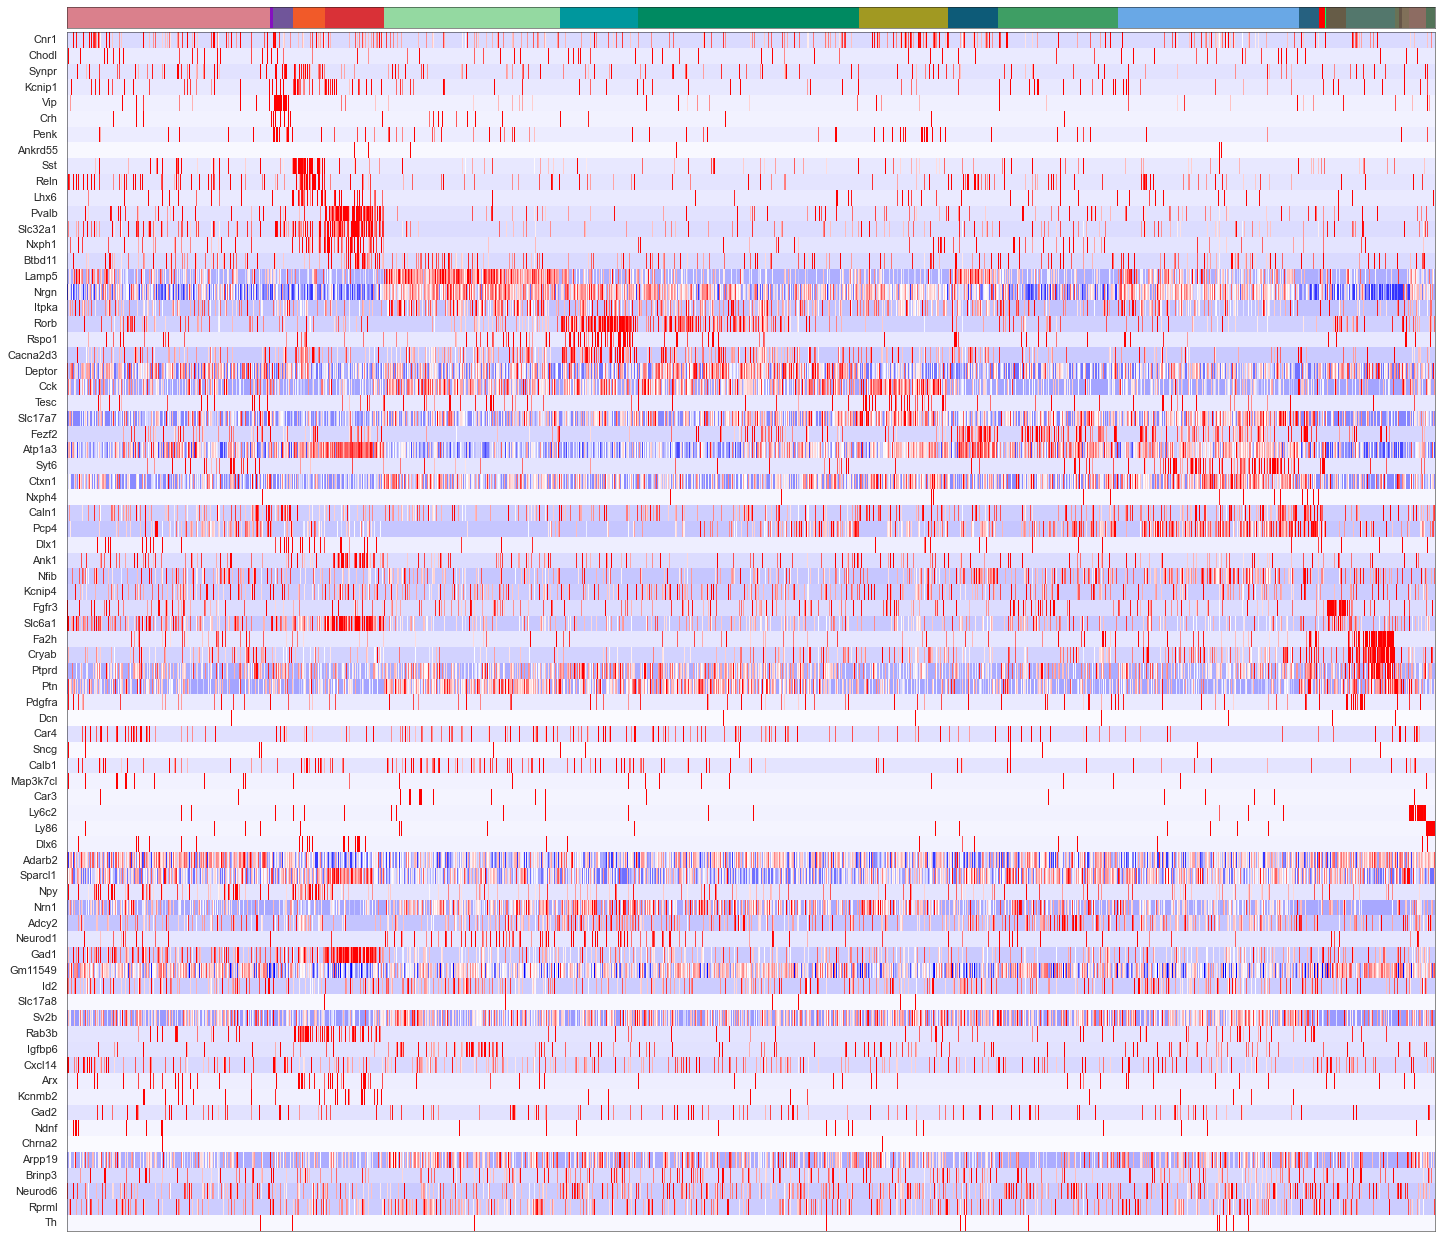

In [14]:
cols = [cell_class_colors[ct] for ct in uniq_celltypes_nwcs]
plot_heatmap(sorted_cbg[:, ::-1], sorted_genes[::-1], calls_nwcs, uniq_celltypes_nwcs, cols, [20, 17]).savefig("baristaseq_heatmap_nwcs.pdf")

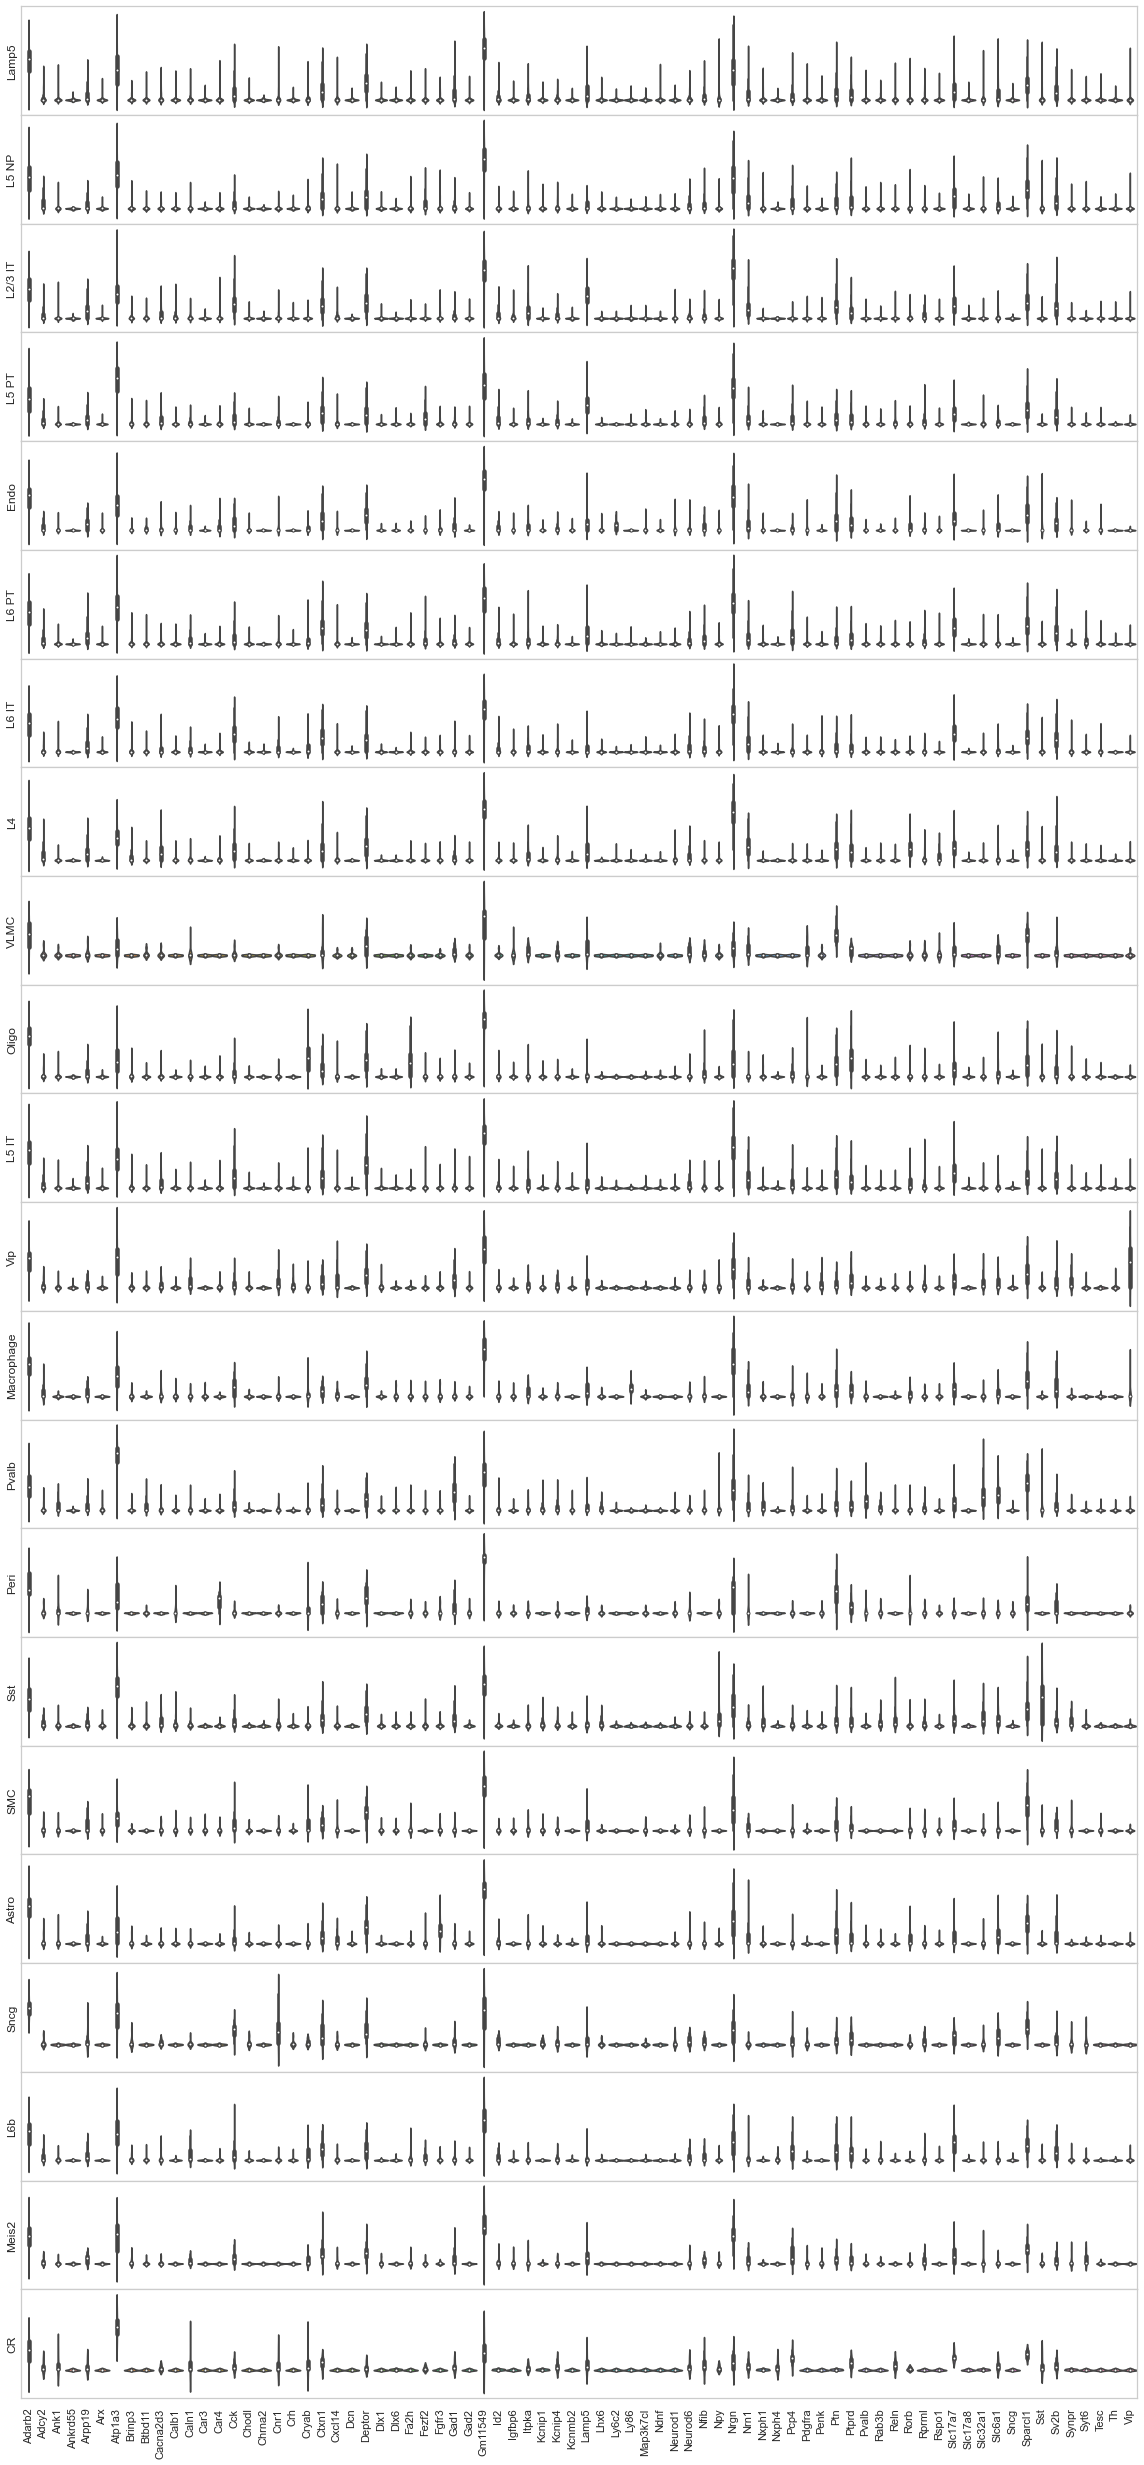

In [77]:
from sklearn import preprocessing
fig, axes = plt.subplots(len(uniq_celltypes_nwcs), 1, figsize=[20, len(uniq_celltypes_nwcs)*2])
plt.subplots_adjust(hspace=0)
for idx, cell_type in enumerate(uniq_celltypes_nwcs):
    cl_vecs = cell_by_gene_normalized_scaled[calls_nwcs.subclass == cell_type]
    sns.violinplot(ax=axes[idx], data=cl_vecs, width=1)
    axes[idx].set_ylabel(cell_type)
    axes[idx].set_yticks([])
axes[idx].set_xticklabels(ds.genes, rotation=90)
pass

In [ ]:
taxon_orders = [
    "Lamp5",
    "Sncg",
    "Serpinf1",
    "Vip",
    "Sst",
    "Pvalb",
    "L2/3 IT",
    "L4",
    "L5 IT",
    "L6 IT",
    #"NP",
    "L5 NP", # ?
    "L5 PT", # ?
    "L6 CT",
    "L6 PT", # ?
    "L6b",
    "Meis2",
    "CR",
    "Astro",
    "Oligo",
    "VLMC",
    "Peri",
    "SMC",
    "Endo",
    "Macrophage"
]

indices = [taxon_orders.index(ct) for ct in uniq_celltypes_nwcs]

fig, axes = plt.subplots(len(indices), 1, figsize=[20, len(indices)*2])
plt.subplots_adjust(hspace=0)
for idx in range(len(indices)):
    acc_idx = np.sum(acc_lens[:idx]).astype(int)
    cl_vecs = gene_exp_heatmap.T[acc_idx:acc_idx+acc_lens[idx]]
    sns.violinplot(ax=axes[idx], data=cl_vecs, width=1)
    axes[idx].set_ylabel(ylabels[idx])
    axes[idx].set_yticks([])
axes[idx].set_xticklabels(heatmap_genes_ordered, rotation=90)
pass

In [23]:
analysis.map_celltypes(centroids_nwcs)

Generating cell-type map for centroid #0...
Processing chunk (0/1)...
Generating cell-type map for centroid #1...
Processing chunk (0/1)...
Generating cell-type map for centroid #2...
Processing chunk (0/1)...
Generating cell-type map for centroid #3...
Processing chunk (0/1)...
Generating cell-type map for centroid #4...
Processing chunk (0/1)...
Generating cell-type map for centroid #5...
Processing chunk (0/1)...
Generating cell-type map for centroid #6...
Processing chunk (0/1)...
Generating cell-type map for centroid #7...
Processing chunk (0/1)...
Generating cell-type map for centroid #8...
Processing chunk (0/1)...
Generating cell-type map for centroid #9...
Processing chunk (0/1)...
Generating cell-type map for centroid #10...
Processing chunk (0/1)...
Generating cell-type map for centroid #11...
Processing chunk (0/1)...
Generating cell-type map for centroid #12...
Processing chunk (0/1)...
Generating cell-type map for centroid #13...
Processing chunk (0/1)...
Generating cell-

In [24]:
analysis.filter_celltypemaps(min_norm=0.4, min_r=0.6)

In [25]:
map_colors_nwcs = [cell_class_colors[ct] for ct in uniq_celltypes_nwcs]

Text(0.5, 1.0, 'BaristaSeq - NWCS (SSAM)')

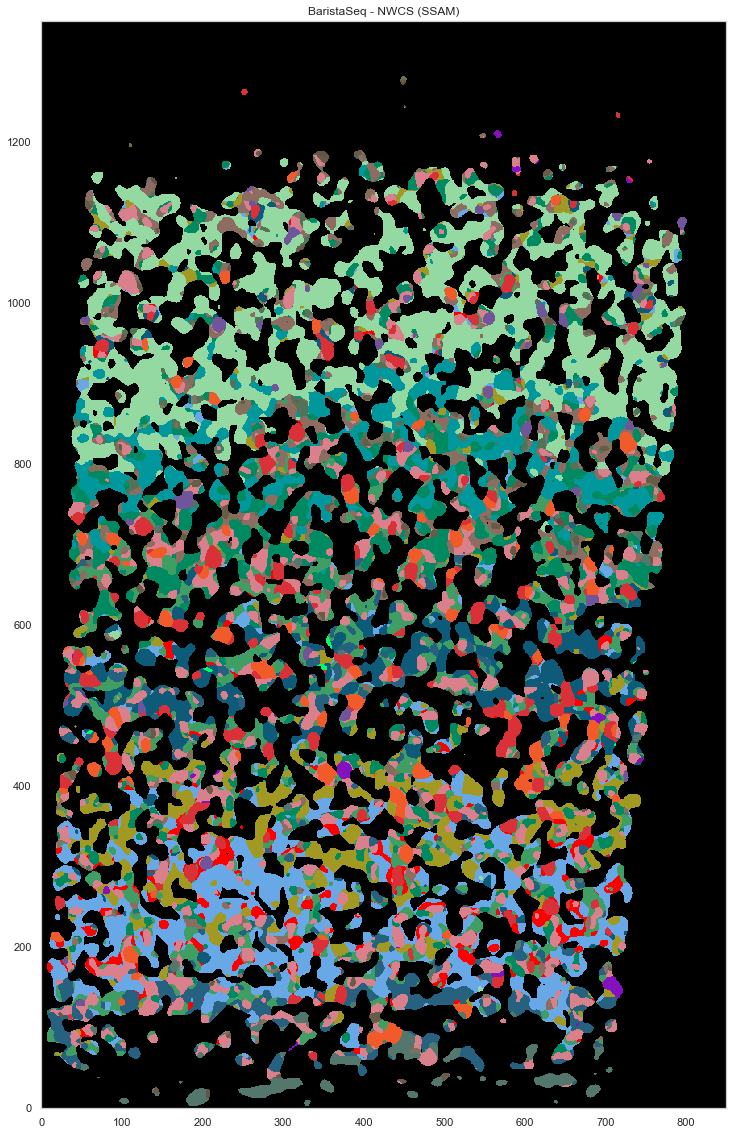

In [26]:
plt.figure(figsize=[20, 20])
ds.plot_celltypes_map(rotate=3, colors=map_colors_nwcs)
plt.title("BaristaSeq - NWCS (SSAM)")

In [30]:
ds.centroids = centroids_nwcs # TODO: this should not be necessary!

In [31]:
analysis.bin_celltypemaps(step=10, radius=100)

In [42]:
analysis.find_domains(n_clusters=20, merge_remote=False, merge_thres=0.8, norm_thres=4000)

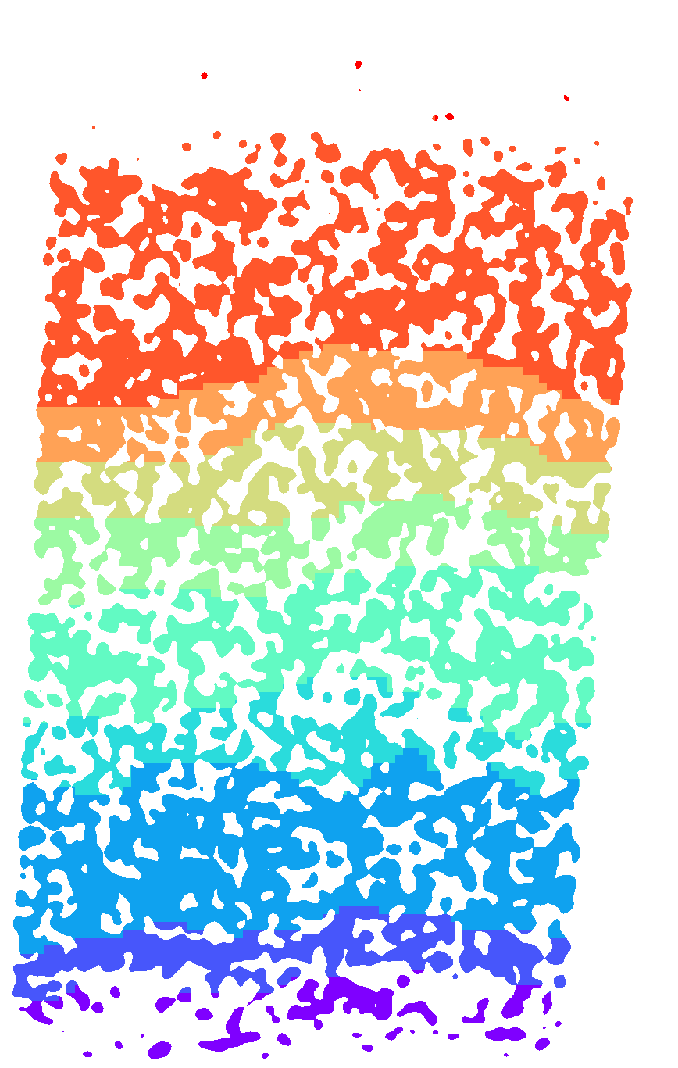

In [44]:
plt.figure(figsize=[15, 15])
ds.plot_domains(rotate=3, cmap='rainbow', z=0)
plt.axis('off')
plt.tight_layout()

In [55]:
layer_annotations = ds.inferred_domains[ds.local_maxs]

In [15]:
calls_gmcs = pd.read_csv("consensus_calls/charles/barista_jeremy_pciseq_renee_eeshit_gabriele_consensus_df.csv")

In [16]:
for cl in calls_gmcs.subclass.unique():
    if cl == "L23_IT":
        calls_gmcs.subclass.loc[calls_gmcs.subclass == "L23_IT"] = "L2/3 IT"
    elif "_" in cl:
        calls_gmcs.subclass.loc[calls_gmcs.subclass == cl] = cl.replace("_", " ")

/tmp/ipykernel_590/1845947111.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_gmcs.subclass.loc[calls_gmcs.subclass == cl] = cl.replace("_", " ")
/tmp/ipykernel_590/1845947111.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_gmcs.subclass.loc[calls_gmcs.subclass == "L23_IT"] = "L2/3 IT"


In [17]:
uniq_celltypes_gmcs = [cl for cl in cell_class_colors.keys() if cl in calls_gmcs.subclass.unique()]
centroids_gmcs = []
for cell_type in uniq_celltypes_gmcs:
    centroids_gmcs.append(np.mean(cell_by_gene_normalized[calls_gmcs.subclass == cell_type], axis=0))

In [18]:
centroids_scaled_gmcs = []
for cell_type in uniq_celltypes_gmcs:
    centroids_scaled_gmcs.append(np.mean(cell_by_gene_normalized_scaled[calls_gmcs.subclass == cell_type], axis=0))
    
sorted_cbg, sorted_genes = sort_genes(centroids_scaled_gmcs, cell_by_gene_normalized_scaled, ds.genes)

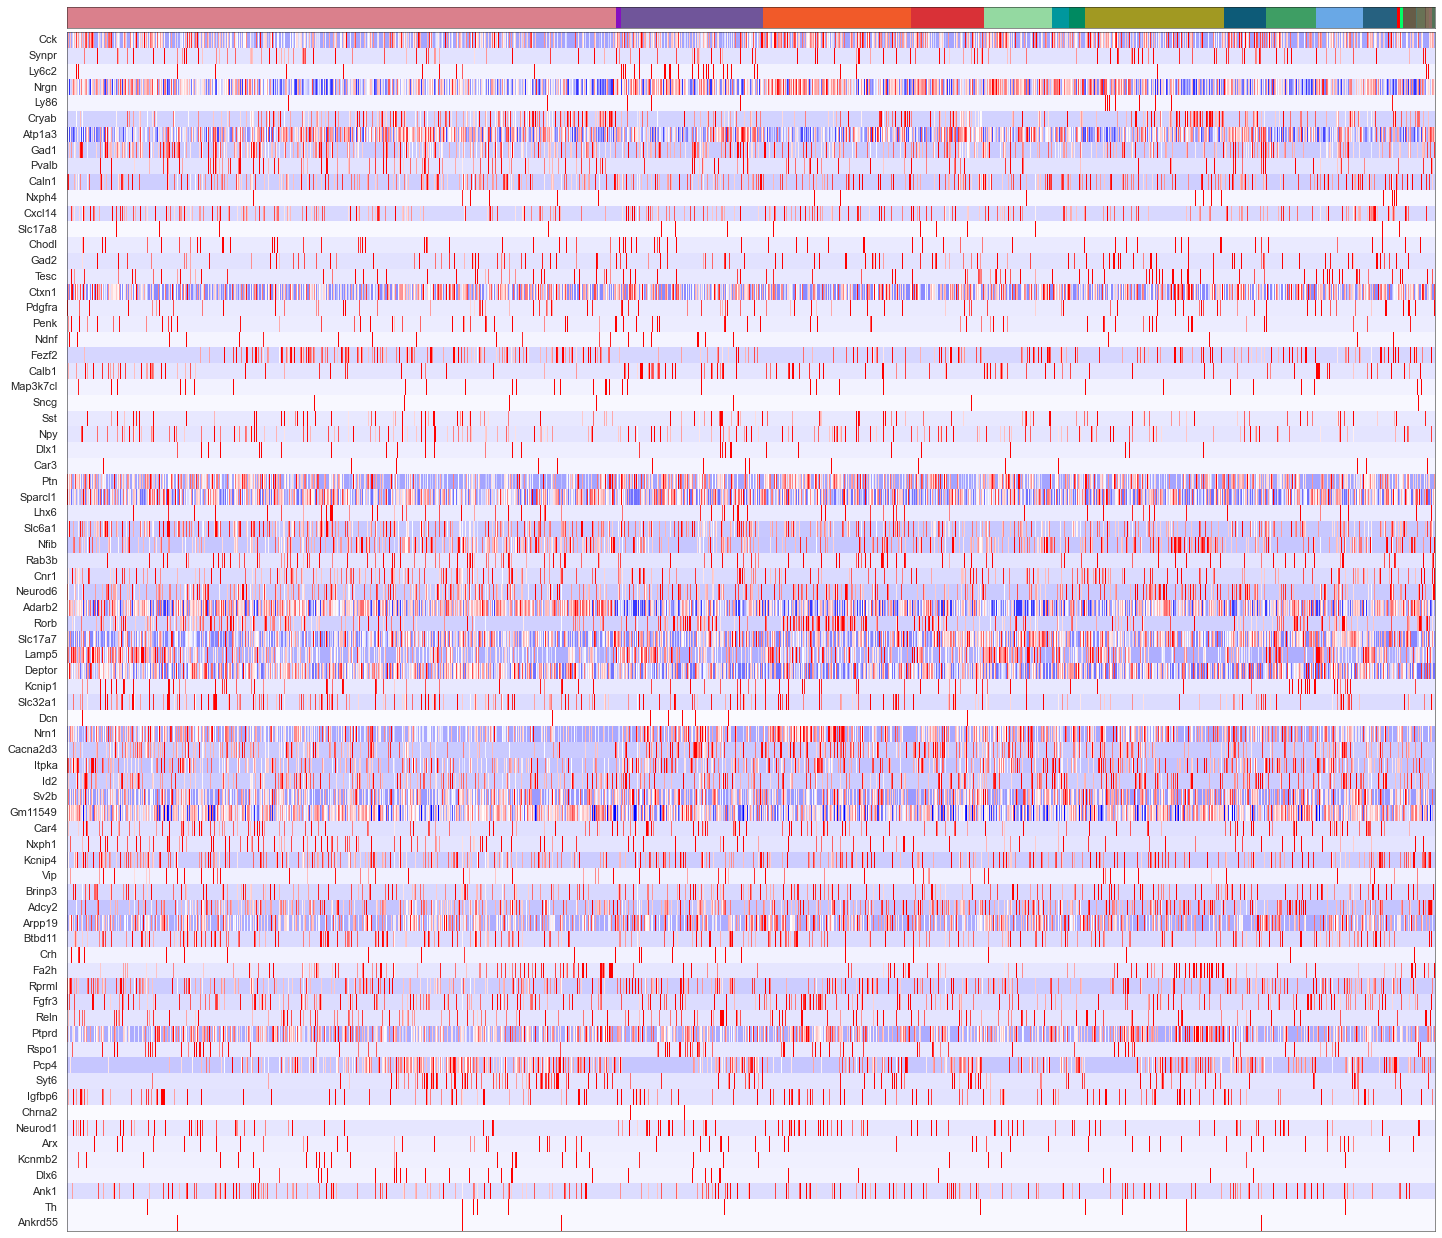

In [19]:
cols = [cell_class_colors[ct] for ct in uniq_celltypes_gmcs]
plot_heatmap(sorted_cbg[:, ::-1], sorted_genes[::-1], calls_gmcs, uniq_celltypes_gmcs, cols, [20, 17]).savefig("baristaseq_heatmap_gmcs.pdf")

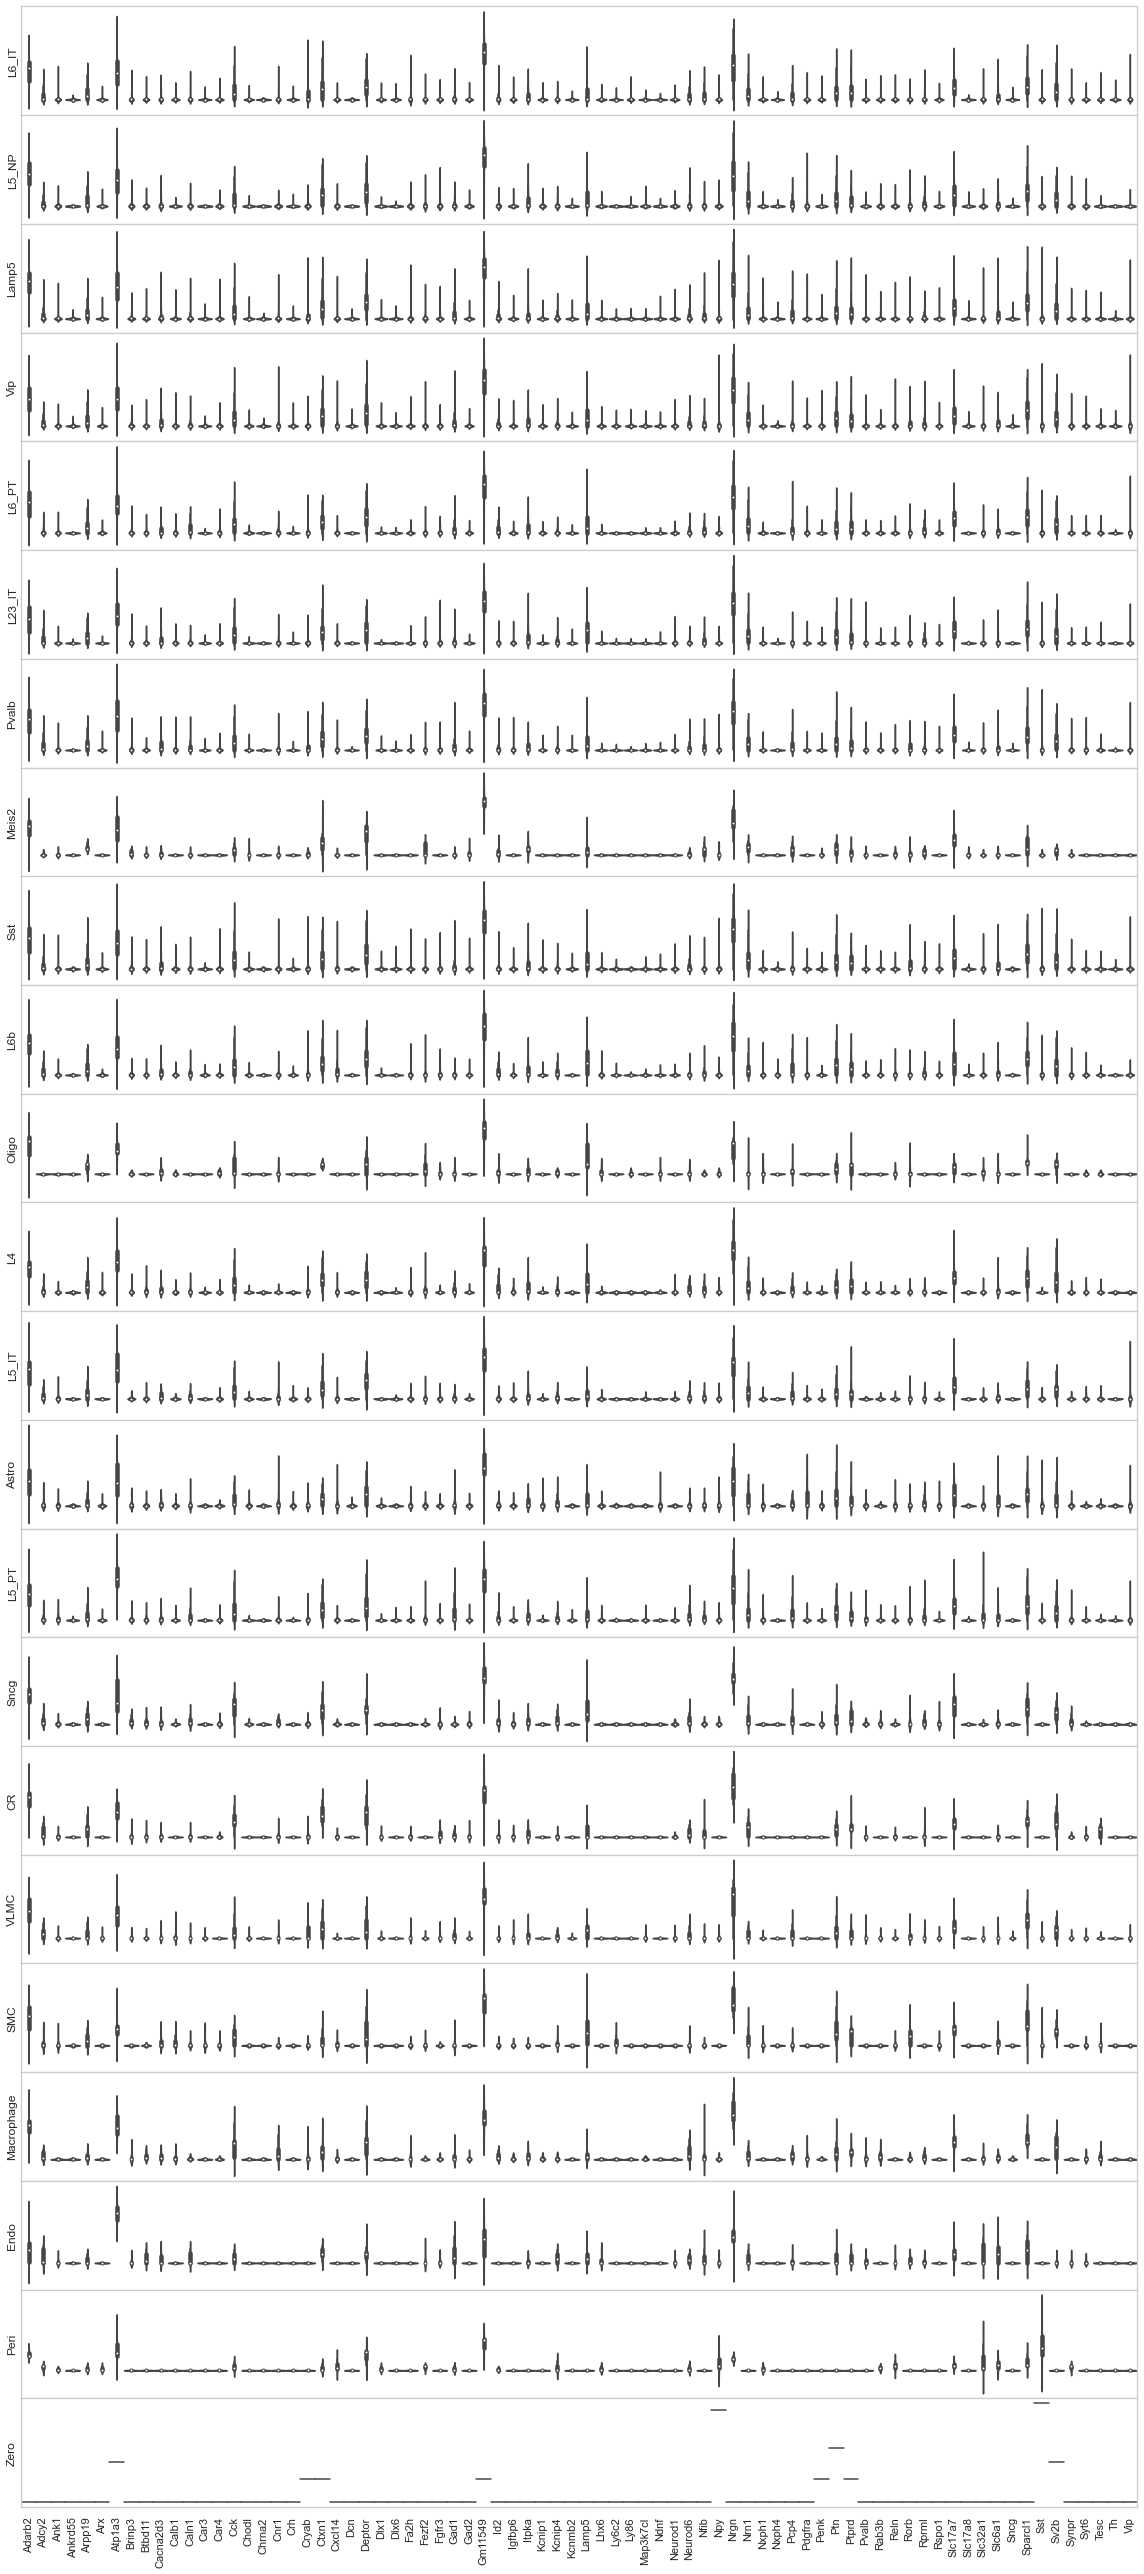

In [88]:
from sklearn import preprocessing
fig, axes = plt.subplots(len(uniq_celltypes_gmcs), 1, figsize=[20, len(uniq_celltypes_gmcs)*2])
plt.subplots_adjust(hspace=0)
for idx, cell_type in enumerate(uniq_celltypes_gmcs):
    cl_vecs = cell_by_gene_normalized_scaled[calls_gmcs.subclass == cell_type]
    if len(cl_vecs) == 1:
        cl_vecs = np.array([cl_vecs[0], cl_vecs[0]])
    sns.violinplot(ax=axes[idx], data=cl_vecs, width=1)
    axes[idx].set_ylabel(cell_type)
    axes[idx].set_yticks([])
axes[idx].set_xticklabels(ds.genes, rotation=90)
pass

In [59]:
analysis.map_celltypes(centroids_gmcs)

Generating cell-type map for centroid #0...
Processing chunk (0/1)...
Generating cell-type map for centroid #1...
Processing chunk (0/1)...
Generating cell-type map for centroid #2...
Processing chunk (0/1)...
Generating cell-type map for centroid #3...
Processing chunk (0/1)...
Generating cell-type map for centroid #4...
Processing chunk (0/1)...
Generating cell-type map for centroid #5...
Processing chunk (0/1)...
Generating cell-type map for centroid #6...
Processing chunk (0/1)...
Generating cell-type map for centroid #7...
Processing chunk (0/1)...
Generating cell-type map for centroid #8...
Processing chunk (0/1)...
Generating cell-type map for centroid #9...
Processing chunk (0/1)...
Generating cell-type map for centroid #10...
Processing chunk (0/1)...
Generating cell-type map for centroid #11...
Processing chunk (0/1)...
Generating cell-type map for centroid #12...
Processing chunk (0/1)...
Generating cell-type map for centroid #13...
Processing chunk (0/1)...
Generating cell-

In [60]:
analysis.filter_celltypemaps(min_norm=0.4, min_r=0.6)

In [61]:
map_colors_gmcs = [cell_class_colors[ct.replace("_", " ").replace("L23", "L2/3")] for ct in uniq_celltypes_gmcs]

Text(0.5, 1.0, 'BaristaSeq - GMCS (SSAM)')

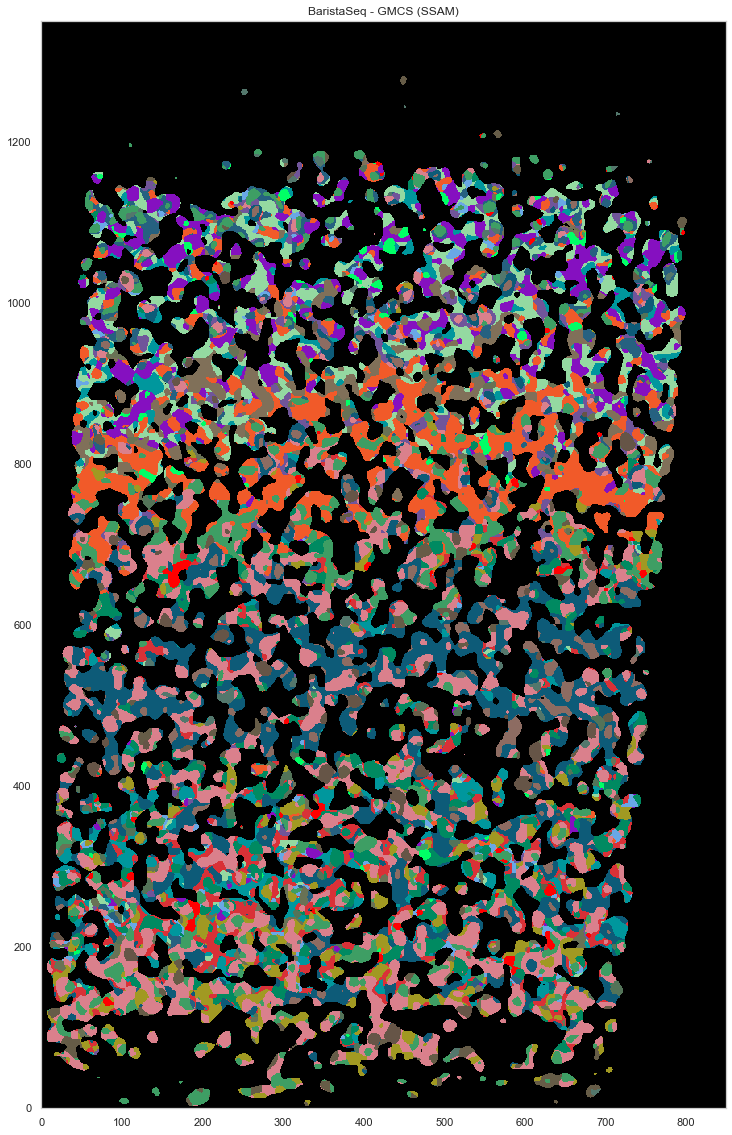

In [62]:
plt.figure(figsize=[20, 20])
ds.plot_celltypes_map(rotate=3, colors=map_colors_gmcs)
plt.title("BaristaSeq - GMCS (SSAM)")

In [64]:
closest_nwcs_clusters = []
closest_nwcs_clusters_r = []
closest_gmcs_clusters = []
closest_gmcs_clusters_r = []
for v in ds.normalized_vectors:
    corrs = [ssam.utils.corr(v, centroids_nwcs[i]) for i in range(len(centroids_nwcs))]
    idx = np.argmax(corrs)
    closest_nwcs_clusters.append(uniq_celltypes_nwcs[idx])
    closest_nwcs_clusters_r.append(corrs[idx])
    
    corrs = [ssam.utils.corr(v, centroids_gmcs[i]) for i in range(len(centroids_gmcs))]
    idx = np.argmax(corrs)
    closest_gmcs_clusters.append(uniq_celltypes_gmcs[idx])
    closest_gmcs_clusters_r.append(corrs[idx])
    
df = pd.DataFrame(ds.normalized_vectors, columns=ds.genes)
df.to_csv("baristaseq_ssam_localmax_expression.csv")

df = pd.DataFrame()
df['x'] = ds.local_maxs[0]
df['y'] = ds.local_maxs[1]
df['closest_consensus_nwcs_cluster'] = closest_nwcs_clusters
df['closest_consensus_nwcs_cluster_r'] = closest_nwcs_clusters_r
df['closest_consensus_gmcs_cluster'] = closest_gmcs_clusters
df['closest_consensus_gmcs_cluster_r'] = closest_gmcs_clusters_r
df['layer_annotations_nwcs'] = layer_annotations

df.to_csv("baristaseq_ssam_localmax_metadata_with_layer.csv")

Text(0.5, 1.0, 'BaristaSeq - NWCS')

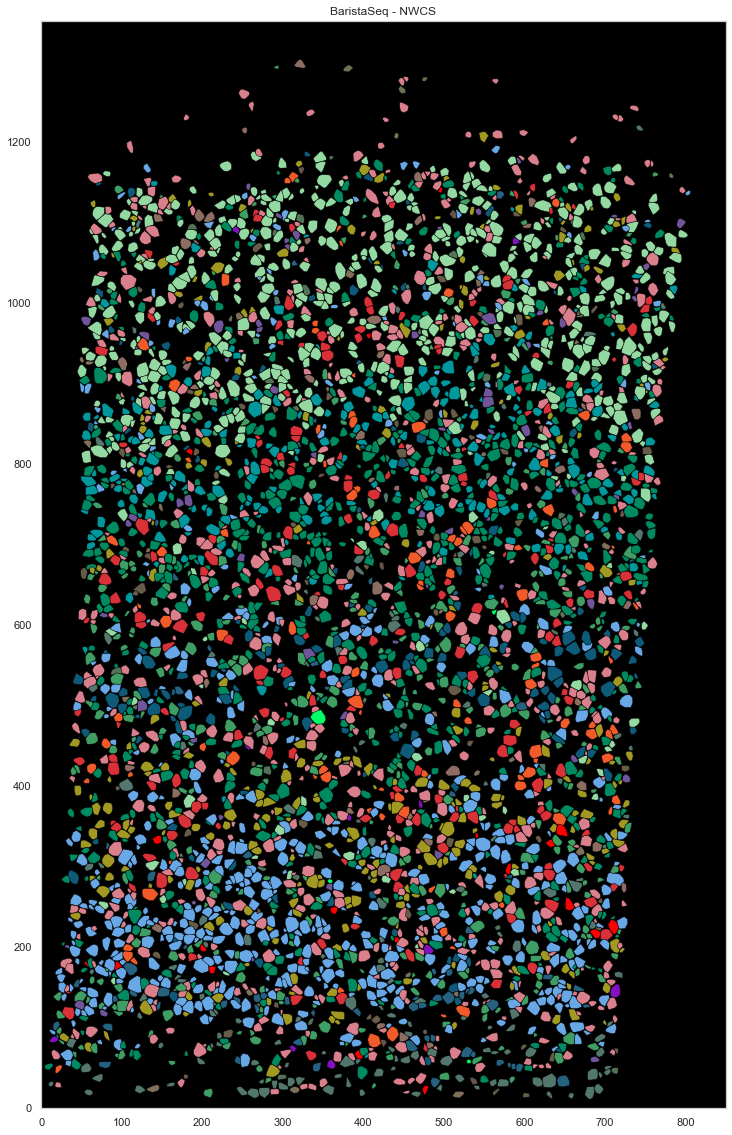

In [83]:
from scipy.spatial import ConvexHull

plt.figure(figsize=[20, 20])
plt.gca().set_facecolor('black')
good_ids = cell_by_gene.index.astype(int)
i = 0
for cid, sdf in locations.groupby("cell"):
    if cid in good_ids:
        points = sdf.iloc[:, :2].to_numpy()
        hull = ConvexHull(points)
        plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], cell_class_colors[calls_nwcs.subclass[i]], edgecolor="black", linewidth=0.5)
        i += 1
plt.xlim([0, ds.shape[0]])
plt.ylim([0, ds.shape[1]])
plt.gca().set_aspect('equal', adjustable='box')
plt.title("BaristaSeq - NWCS")

Text(0.5, 1.0, 'BaristaSeq - GMCS')

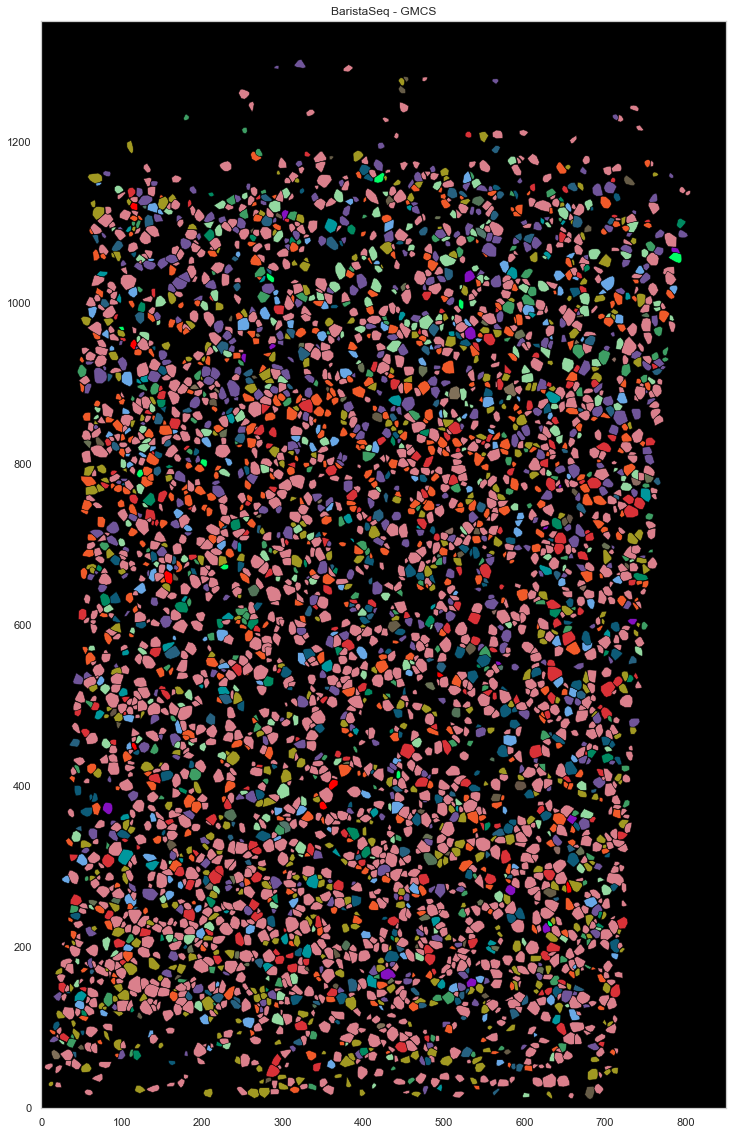

In [84]:
from scipy.spatial import ConvexHull

plt.figure(figsize=[20, 20])
plt.gca().set_facecolor('black')
good_ids = cell_by_gene.index.astype(int)
i = 0
for cid, sdf in locations.groupby("cell"):
    if cid in good_ids:
        points = sdf.iloc[:, :2].to_numpy()
        hull = ConvexHull(points)
        plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], cell_class_colors[calls_gmcs.subclass[i].replace("_", " ").replace("L23", "L2/3")], edgecolor="black", linewidth=0.5)
        i += 1
plt.xlim([0, ds.shape[0]])
plt.ylim([0, ds.shape[1]])
plt.gca().set_aspect('equal', adjustable='box')
plt.title("BaristaSeq - GMCS")

In [39]:
analysis.bin_celltypemaps(step=10, radius=100)

In [47]:
analysis.find_domains(n_clusters=20, merge_remote=True, merge_thres=0.8, norm_thres=1500)

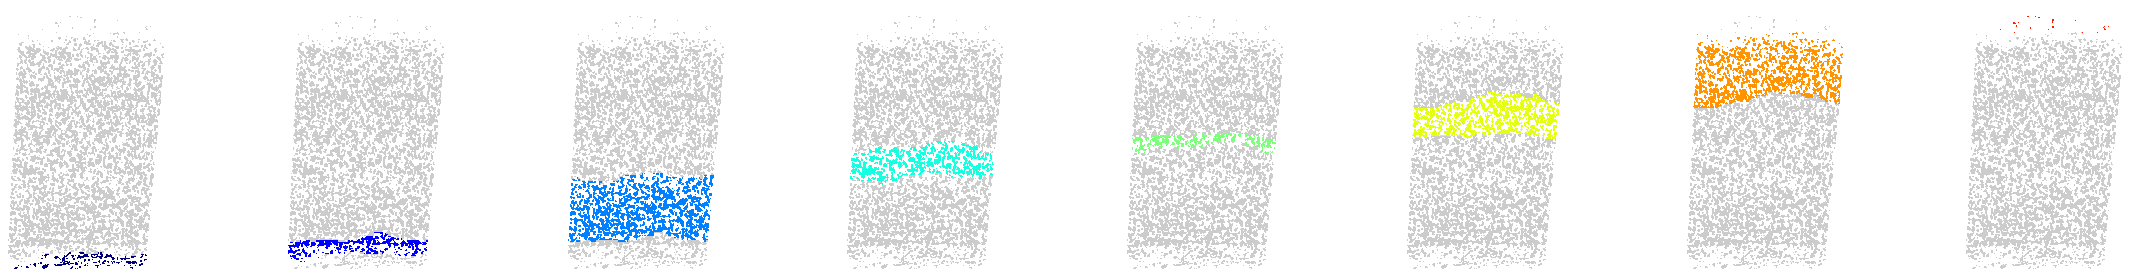

In [48]:
from matplotlib.colors import ListedColormap
cmap_jet = plt.get_cmap('jet')
num_domains = np.max(ds.inferred_domains_cells) + 1

fig, axs = plt.subplots(1, num_domains, figsize=(4*num_domains, 4))
for domain_idx in range(num_domains):
    ax = axs[domain_idx]
    plt.sca(ax)
    plt.axis('off')
    cmap = ListedColormap([cmap_jet(lbl_idx / num_domains) if domain_idx == lbl_idx else "#cccccc" for lbl_idx in range(num_domains)])
    ds.plot_domains(rotate=3, cmap=cmap)
plt.tight_layout()

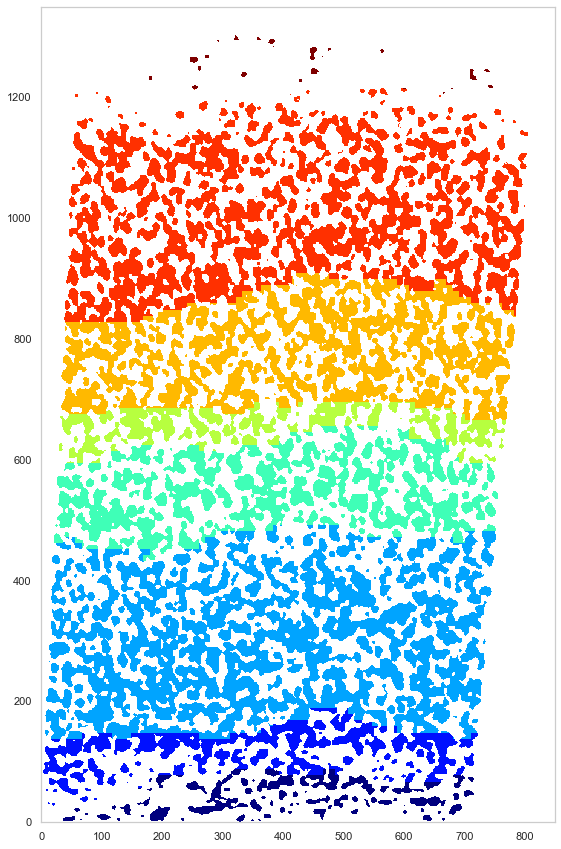

In [49]:
plt.figure(figsize=[15, 15])
ds.plot_domains(rotate=3)